In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.exceptions import NotFittedError

In [2]:
data = pd.read_csv('E:/Final Dissertation/Cleaned_Dataset/PM10_aeroequal_and_council.csv')
data.head()

,Datetime,PM10_mg/m³_aeroequal,PM10_µg/m³_council
0,2024-08-15 15:00:00,1.983333,17.0
1,2024-08-15 16:00:00,2.800000,14.8
2,2024-08-15 17:00:00,1.100000,18.1
3,2024-08-15 18:00:00,1.250000,14.4
4,2024-08-16 12:00:00,0.816667,12.5


In [3]:
X = data[['PM10_mg/m³_aeroequal']].values
y = data['PM10_µg/m³_council'].values

| **Data** | **Split** |
|----------|-----------|
| **Train Set** | 70% of the Cleaned dataset |
| **Test Set** | 30% of the Cleaned dataset |

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
display(X_train[0:5])
print()
display(X_train_scaled[0:5])
print()
print()
display(X_test[0:5])
display(X_test_scaled[0:5])

array([[0.53333333],
       [1.98333333],
       [0.81666667],
       [1.13333333],
       [8.09090909]])

array([[-0.78989773],
       [-0.17158621],
       [-0.66907824],
       [-0.53404469],
       [ 2.43281684]])

array([[1.11764706],
       [4.625     ],
       [2.2       ],
       [1.03333333],
       [1.48333333]])

array([[-0.54073366],
       [ 0.95487787],
       [-0.07919484],
       [-0.57668686],
       [-0.38479708]])

#### Experimented List of Models and Parameters

In [7]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'AdaBoost': AdaBoostRegressor(random_state=42)
}

params = {
    'Linear Regression': {
        'poly__degree': [1, 2, 3]
    },
    'Ridge': {
        'ridge__alpha': [0.001, 0.01, 0.1],
        'poly__degree': [1, 2, 3]
    },
    'Lasso': {
        'lasso__alpha': [0.001, 0.01, 0.1],
        'poly__degree': [1, 2, 3]
    },
    'ElasticNet': {
        'elasticnet__alpha': [0.001, 0.01, 0.1],
        'elasticnet__l1_ratio': [0.1, 0.5, 0.9]
    },
    'Random Forest': {
        'randomforest__n_estimators': [50, 100, 150, 200],
        'randomforest__max_depth': [5, 7, 10]
    },
    'Gradient Boosting': {
        'gradientboosting__n_estimators': [50, 100, 150, 200],
        'gradientboosting__learning_rate': [0.001, 0.01, 0.1],
        'gradientboosting__max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'xgboost__n_estimators': [50, 100, 150, 200],
        'xgboost__learning_rate': [0.001, 0.01, 0.1],
        'xgboost__max_depth': [3, 5, 7],
        'xgboost__subsample': [0.6, 0.8, 1.0]
    },
    'K-Nearest Neighbors': {
        'k-nearestneighbors__n_neighbors': [3, 5, 7, 9],
        'k-nearestneighbors__weights': ['uniform', 'distance'],
        'k-nearestneighbors__p': [1, 2]
    },
    'AdaBoost': {
        'adaboost__n_estimators': [50, 100, 150, 200],
        'adaboost__learning_rate': [0.001, 0.01, 0.1],
        'adaboost__loss': ['linear', 'square', 'exponential']
    }
}

polynomial_models = ['Linear Regression', 'Ridge', 'Lasso']

#### 1. polynomial_models is the list of models for which a polynomial feature transformation is required
#### 2. We create a pipeline for those models to transform the features before feeding them to the model.
#### 3. We prefer a Grid Search CV over a Random Search CV due to the small dataset size. As exhaustive hyperparameter tuning is necessary.
#### 4. neg_root_mean_squared_error is used for scoring, while R2 is used for selecting the best model under baseline models.

In [8]:
best_models = []
best_score = float('-inf')
best_model_name = ''
best_params = {}

for model_name in models:
    print(f"Training {model_name}...")
    steps = []

    if model_name in polynomial_models:
        steps.append(('poly', PolynomialFeatures(include_bias=False)))
        
    model_param_key = model_name.lower().replace(' ', '')
    steps.append((model_param_key, models[model_name]))
    pipeline = Pipeline(steps)
    
    grid_search = GridSearchCV(pipeline, params[model_name], cv=5, scoring='neg_root_mean_squared_error', refit=True, n_jobs=-1, verbose=True)
    
    try:
        grid_search.fit(X_train_scaled, y_train)
        model_score = grid_search.best_score_
        
        best_models.append({
            'name': model_name,
            'model': grid_search.best_estimator_,
            'params': grid_search.best_params_,
            'rmse': model_score
        })

    except (ValueError, NotFittedError) as e:
        print(f"Skipped {model_name} due to error: {str(e)}")

Training Linear Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Training Ridge...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training Lasso...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training ElasticNet...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training Gradient Boosting...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Training XGBoost...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Training K-Nearest Neighbors...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Training AdaBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


## Results

In [9]:
results = []
for model in best_models:
    result = {}
    result['name'] = model['name']
    result['params'] = model['params']
    test_predictions = model['model'].predict(X_test_scaled)
    test_rmse = root_mean_squared_error(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    result['rmse'] = test_rmse
    result['mse'] = test_mse
    result['r2'] = test_r2
    result['mae'] = test_mae
    result['comparison_df'] = pd.DataFrame({'Actual': y_test, 'Predicted': test_predictions})
    results.append(result)

#### For showcasing model with the best R2

In [10]:
results = sorted(results, key=lambda x: x['r2'], reverse=True)

Results For Model: AdaBoost
Best Hyperparameters: {'poly__degree': 1}
Test RMSE: 2.5611
Test MSE: 6.5591
Test R2: 0.5198
Test MAE: 2.2997


,Actual,Predicted
0,14.0,11.938451
1,21.1,17.397076
2,16.1,13.622958
3,13.4,11.807231
4,12.9,12.507583
5,9.7,12.403827
6,18.1,15.464624
7,20.6,15.879647
8,18.9,17.591618
9,11.2,12.689155


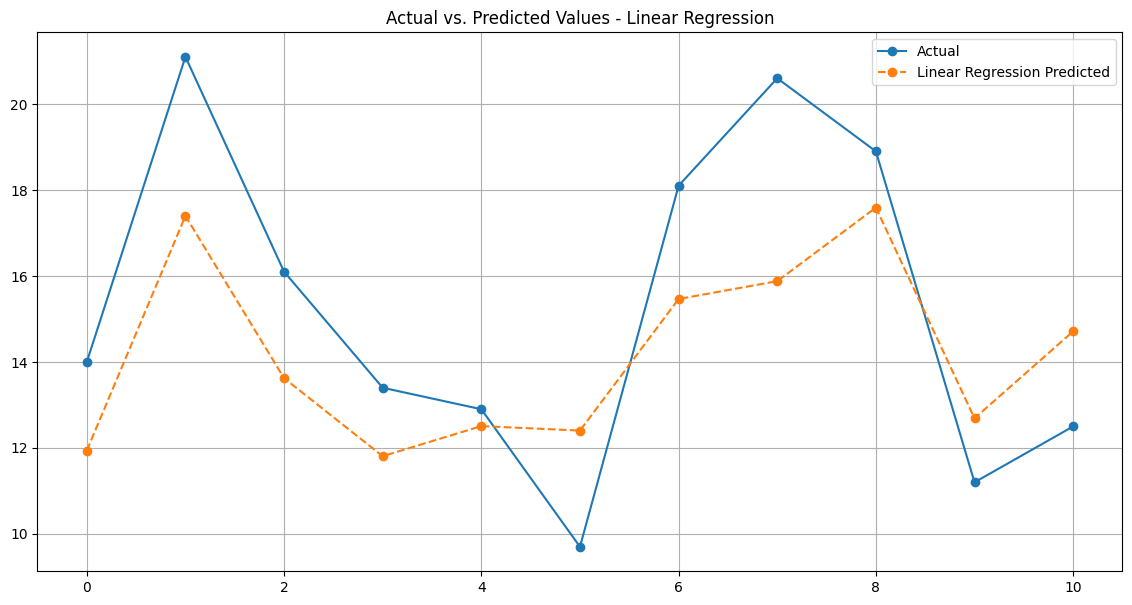


Results For Model: Linear Regression
Best Hyperparameters: {'poly__degree': 1, 'ridge__alpha': 0.001}
Test RMSE: 2.5611
Test MSE: 6.5593
Test R2: 0.5197
Test MAE: 2.2997


,Actual,Predicted
0,14.0,11.938530
1,21.1,17.396936
2,16.1,13.622969
3,13.4,11.807315
4,12.9,12.507639
5,9.7,12.403887
6,18.1,15.464562
7,20.6,15.879568
8,18.9,17.591471
9,11.2,12.689204


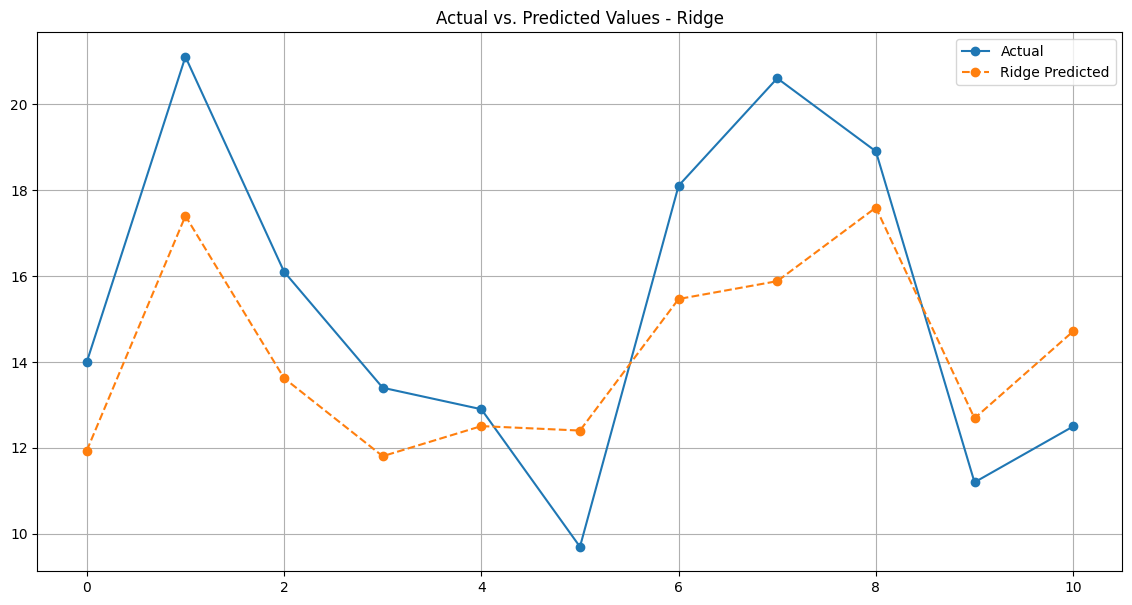


Results For Model: Ridge
Best Hyperparameters: {'lasso__alpha': 0.001, 'poly__degree': 1}
Test RMSE: 2.5613
Test MSE: 6.5604
Test R2: 0.5197
Test MAE: 2.2998


,Actual,Predicted
0,14.0,11.938992
1,21.1,17.396121
2,16.1,13.623037
3,13.4,11.807808
4,12.9,12.507967
5,9.7,12.404240
6,18.1,15.464198
7,20.6,15.879108
8,18.9,17.590610
9,11.2,12.689490


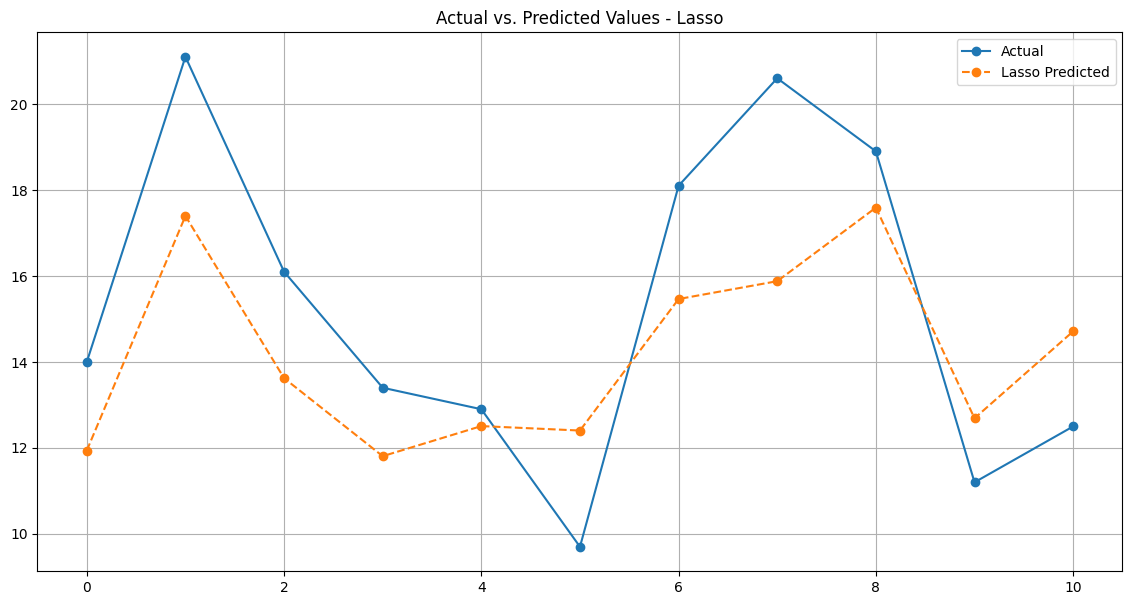


Results For Model: Lasso
Best Hyperparameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.9}
Test RMSE: 2.5614
Test MSE: 6.5608
Test R2: 0.5196
Test MAE: 2.2999


,Actual,Predicted
0,14.0,11.939135
1,21.1,17.395868
2,16.1,13.623058
3,13.4,11.807960
4,12.9,12.508069
5,9.7,12.404350
6,18.1,15.464086
7,20.6,15.878965
8,18.9,17.590343
9,11.2,12.689579


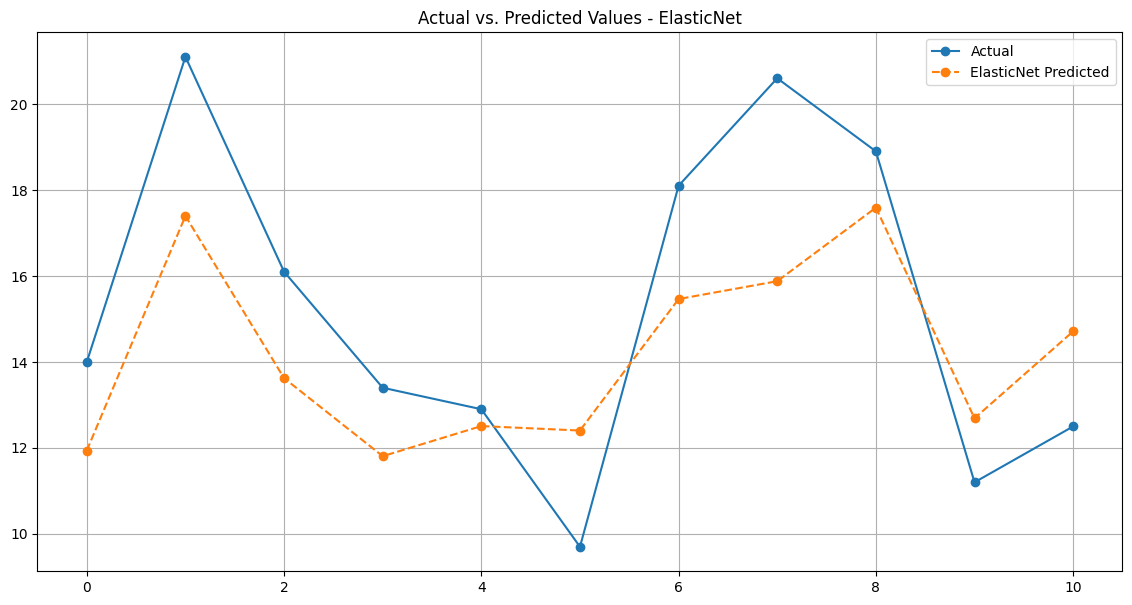


Results For Model: ElasticNet
Best Hyperparameters: {'k-nearestneighbors__n_neighbors': 9, 'k-nearestneighbors__p': 1, 'k-nearestneighbors__weights': 'uniform'}
Test RMSE: 3.9041
Test MSE: 15.2424
Test R2: -0.1160
Test MAE: 3.1333


,Actual,Predicted
0,14.0,12.566667
1,21.1,13.755556
2,16.1,14.088889
3,13.4,12.000000
4,12.9,12.811111
5,9.7,12.811111
6,18.1,13.755556
7,20.6,13.755556
8,18.9,13.755556
9,11.2,12.688889


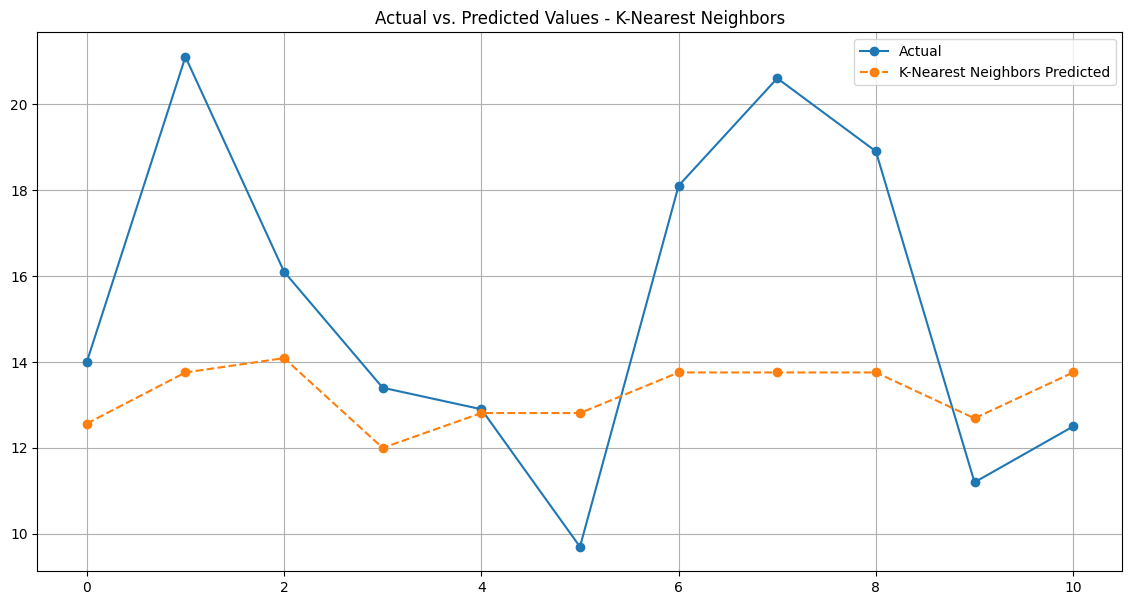


Results For Model: K-Nearest Neighbors
Best Hyperparameters: {'xgboost__learning_rate': 0.01, 'xgboost__max_depth': 3, 'xgboost__n_estimators': 200, 'xgboost__subsample': 1.0}
Test RMSE: 5.0110
Test MSE: 25.1105
Test R2: -0.8385
Test MAE: 3.8030


,Actual,Predicted
0,14.0,13.353668
1,21.1,11.857841
2,16.1,14.280621
3,13.4,13.026610
4,12.9,13.596071
5,9.7,13.596071
6,18.1,11.857841
7,20.6,11.857841
8,18.9,11.857841
9,11.2,13.596071


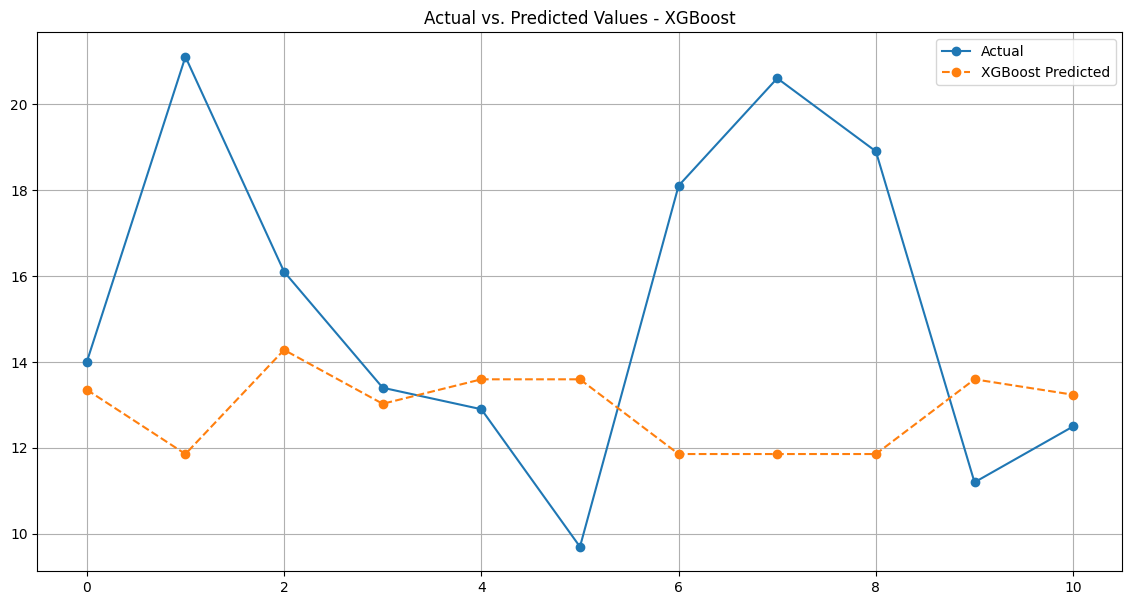


Results For Model: XGBoost
Best Hyperparameters: {'gradientboosting__learning_rate': 0.01, 'gradientboosting__max_depth': 3, 'gradientboosting__n_estimators': 100}
Test RMSE: 5.1254
Test MSE: 26.2698
Test R2: -0.9234
Test MAE: 4.0026


,Actual,Predicted
0,14.0,12.494027
1,21.1,11.748710
2,16.1,13.989035
3,13.4,13.350630
4,12.9,13.734523
5,9.7,13.734523
6,18.1,11.748710
7,20.6,11.748710
8,18.9,11.748710
9,11.2,13.734523


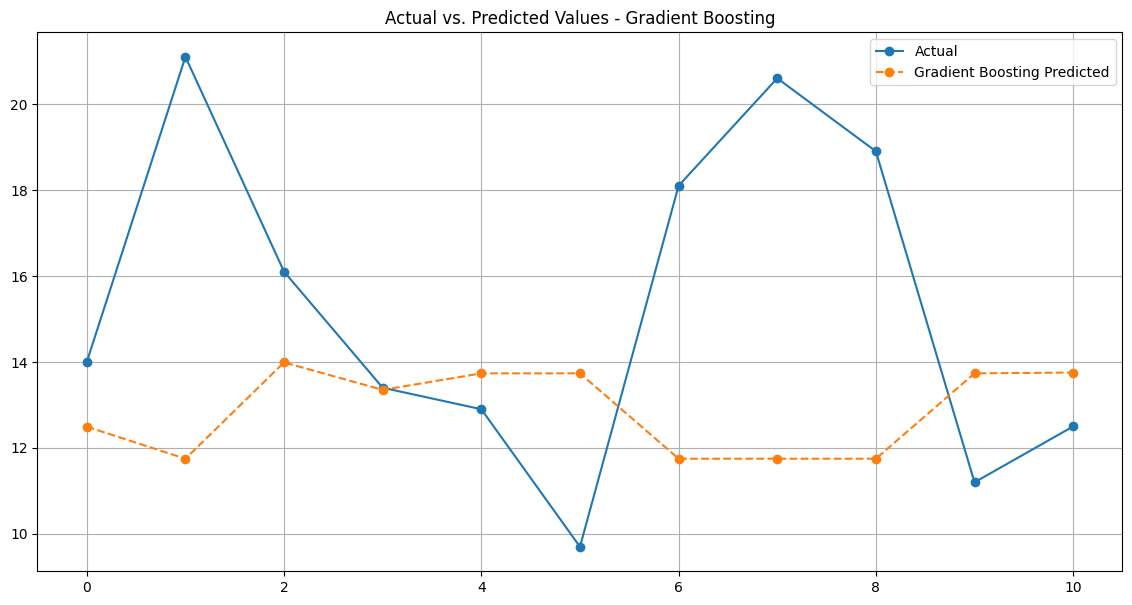


Results For Model: Gradient Boosting
Best Hyperparameters: {'randomforest__max_depth': 5, 'randomforest__n_estimators': 100}
Test RMSE: 5.3546
Test MSE: 28.6719
Test R2: -1.0993
Test MAE: 4.2888


,Actual,Predicted
0,14.0,11.348362
1,21.1,11.426635
2,16.1,13.804591
3,13.4,14.145651
4,12.9,13.765987
5,9.7,13.900279
6,18.1,11.426635
7,20.6,11.426635
8,18.9,11.426635
9,11.2,13.203407


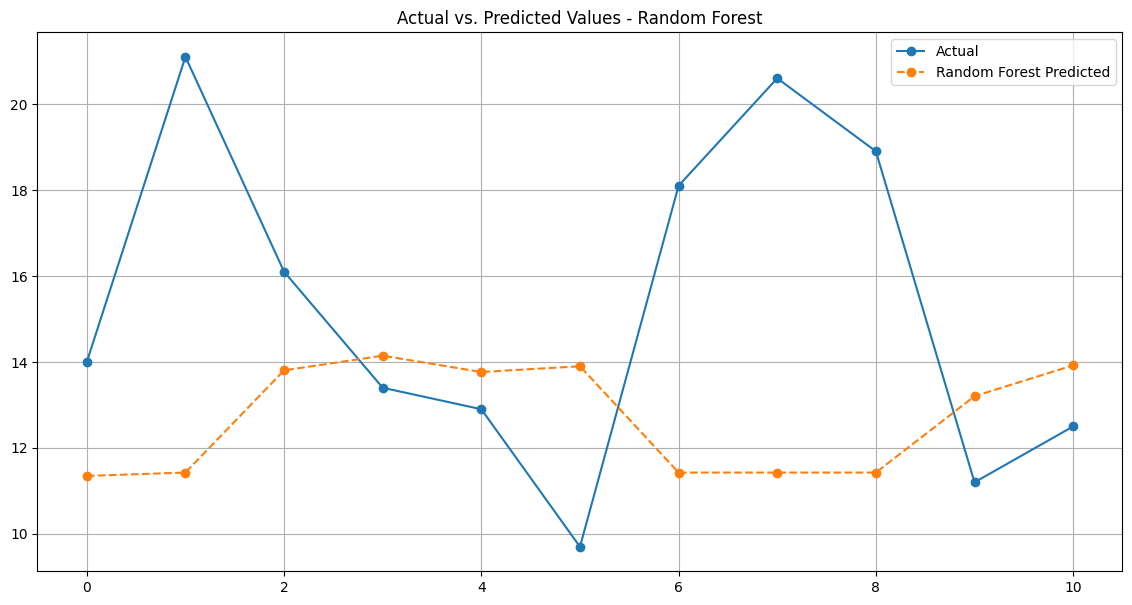


Results For Model: Random Forest
Best Hyperparameters: {'adaboost__learning_rate': 0.001, 'adaboost__loss': 'exponential', 'adaboost__n_estimators': 200}
Test RMSE: 6.3780
Test MSE: 40.6792
Test R2: -1.9784
Test MAE: 4.9392


,Actual,Predicted
0,14.0,11.827273
1,21.1,9.600000
2,16.1,14.006250
3,13.4,12.507692
4,12.9,13.800000
5,9.7,13.760000
6,18.1,9.600000
7,20.6,9.600000
8,18.9,9.600000
9,11.2,13.718182


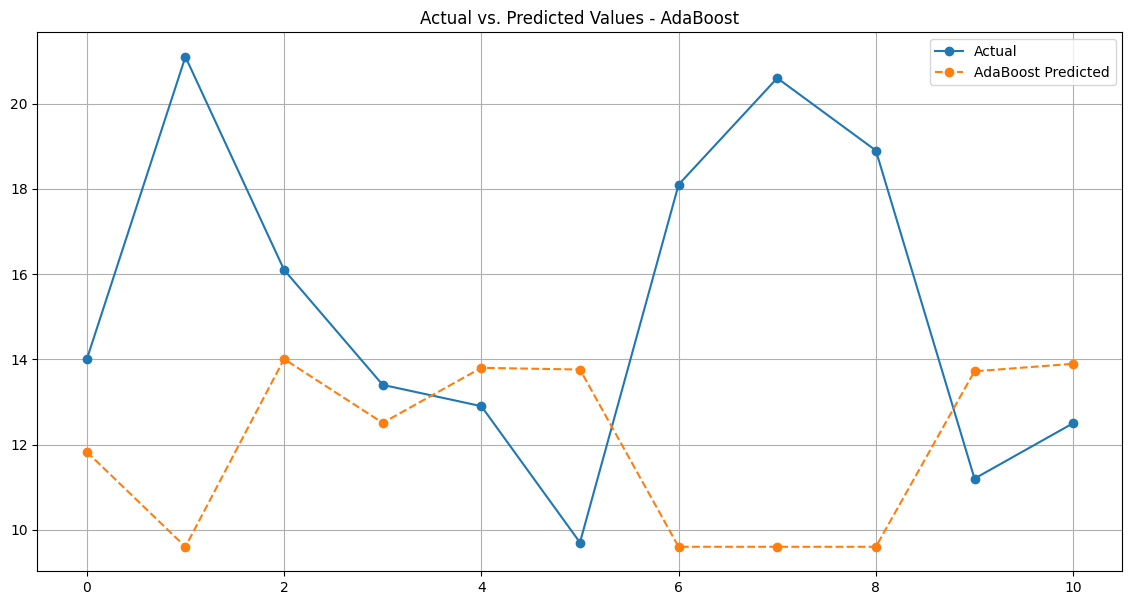

In [11]:
for result in results:
    print(f"Results For Model: {model_name}")
    model_name = result['name']
    print(f"Best Hyperparameters: {result['params']}")
    test_rmse = result['rmse']
    test_mse = result['mse']
    test_r2 = result['r2']
    test_mae = result['mae']
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test R2: {test_r2:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

    comparison_df = result['comparison_df']
    display(comparison_df)

    plt.figure(figsize=(14, 7))
    plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', marker='o')
    plt.plot(comparison_df.index, comparison_df['Predicted'], label=f'{model_name} Predicted', linestyle='--', marker='o')
    plt.title(f'Actual vs. Predicted Values - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    print()

## Model Evaluation

In [12]:
final_scores_df = pd.DataFrame({
    'Model': [result['name'] for result in results],
    'RMSE': [result['rmse'] for result in results],
    'MSE': [result['mse'] for result in results],
    'R2': [result['r2'] for result in results],
    'MAE': [result['mae'] for result in results]
})

display(final_scores_df)

,Model,RMSE,MSE,R2,MAE
0,Linear Regression,2.561073,6.559093,0.519757,2.299654
1,Ridge,2.561110,6.559286,0.519742,2.299678
2,Lasso,2.561331,6.560416,0.519660,2.299824
3,ElasticNet,2.561399,6.560766,0.519634,2.299869
4,K-Nearest Neighbors,3.904146,15.242357,-0.116014,3.133333
5,XGBoost,5.011039,25.110508,-0.838540,3.803038
6,Gradient Boosting,5.125409,26.269813,-0.923422,4.002620
7,Random Forest,5.354615,28.671899,-1.099298,4.288805
8,AdaBoost,6.378022,40.679171,-1.978446,4.939246
